Student Name:	AIDAN KEESHAN
Student ID:	18200117

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from matplotlib.colors import LogNorm

rfcc = pd.read_csv('data/kag_risk_factors_cervical_cancer.csv', na_values = ['?'])

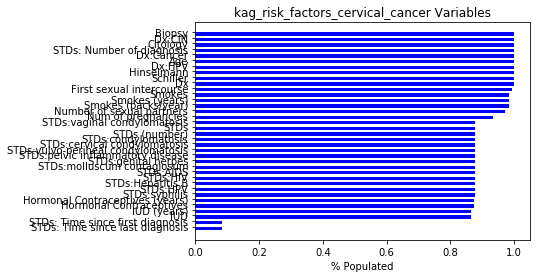

In [2]:
def summary_df(df,title='Data Varaible'):
    summary = (len(df) - df.isnull().sum())/len(df)
    summary = pd.DataFrame({'VARNAME' : summary.index.values, 'VARNULLPER': summary.reset_index(drop=True)}).sort_values(by=['VARNULLPER'])
    fig, ax = plt.subplots()    
    width = 0.6 # the width of the bars 
    ind = np.arange(len(summary))  # the x locations for the groups
    ax.barh(ind, summary['VARNULLPER'], width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(summary['VARNAME'], minor=False)
    plt.title(title)
    plt.xlabel('% Populated')

    plt.show()
    return summary

rfcc_summary = summary_df(rfcc,'kag_risk_factors_cervical_cancer Variables')

In [3]:
rfcc_null_zero = rfcc.replace(np.nan, 0).copy()
rfcc_null_mean = rfcc.copy()
for i, row  in rfcc_summary.iterrows():
    if row['VARNULLPER'] != 1:
        rfcc_null_mean[row['VARNAME']].fillna((rfcc_null_mean[row['VARNAME']].mean()), inplace=True)

In [5]:
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def split_data(df,target):
    y = np.array(df[target])
    X = df.drop(target, 1)
    X = X.replace(np.nan, 0)
    return train_test_split(X, y, test_size=0.33, random_state=42)

def plot_confusion_matrix(y_test, y_pred,title = 'Title'):
    conf_mat = confusion_matrix(y_test, y_pred)
    log_norm = LogNorm(vmin=conf_mat.min().min(), vmax=conf_mat.max().max())
    ax = plt.axes()
    sn.heatmap(conf_mat,cmap="Blues",annot=True,fmt='g',norm=log_norm)
    ax.set_title(title)
    plt.show()

def run_model(df):
    X_train, X_test, y_train, y_test = split_data(df,'Dx:Cancer')
    model = RandomForestClassifier(n_estimators = 200)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))

param_grid = [
        {'bootstrap': [False, True],
         'n_estimators': [80,90, 100, 110, 130,200]
         #'max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
         #'min_samples_leaf': [10, 12, 14],
         #'min_samples_split': [3, 5, 7]
        },
    ]

X_train, X_test, y_train, y_test = split_data(rfcc_null_zero,'Dx:Cancer')
random_forest_classifier = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5,scoring='neg_mean_squared_error', refit=True,n_jobs=8)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
score = grid_search.score(X_test, y_test)
#plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))

In [ ]:
run_model(rfcc_null_zero)

In [ ]:
run_model(rfcc_null_mean)

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# import some data to play with
       # those ? converted to NAN are bothering me abit...        

from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

y = np.array(df['Dx:Cancer'])
X = df.drop('Dx:Cancer', 1)

n_col=36
#X = train.drop(['Dx:Cancer'],axis=1) 
#Y=train['Dx:Cancer']
X=X.fillna(value=0)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
poly = PolynomialFeatures(2)
X=poly.fit_transform(X)


names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         'LogisticRegression',
         'OrthogonalMatchingPursuit',
         #'RANSACRegressor',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
    LogisticRegression(),
    OrthogonalMatchingPursuit(),
    #RANSACRegressor(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

models=zip(names,classifiers,correction)
   
for name, clf,correct in models:
    regr=clf.fit(X,Y)
    #print( name,'% errors', abs(regr.predict(X)+correct-Y).sum()/(Y.sum())*100)
    print(name,'%error',procenterror(regr.predict(X),Y),'rmsle',rmsle(regr.predict(X),Y))
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
    
    # Confusion Matrix
    print(name,'Confusion Matrix')
    conf=confusion_matrix(Y, np.round(regr.predict(X) ) )     
    label = ["0","1"]
    sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
    plt.show()
    
    print('--'*40)

    # Classification Report
    print(name,'Classification Report')
    classif=classification_report(Y,np.round( regr.predict(X) ) )
    print(classif)


    # Accuracy
    print('--'*40)
    logreg_accuracy = round(accuracy_score(Y, np.round( regr.predict(X) ) ) * 100,2)
    print('Accuracy', logreg_accuracy,'%')